In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu118
CUDA available: True


In [2]:
# Define dataset paths
DATA_DIR = 'cell_images'
PARASITIZED_DIR = os.path.join(DATA_DIR, 'Parasitized')
UNINFECTED_DIR = os.path.join(DATA_DIR, 'Uninfected')

# Valid image extensions
VALID_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

# Count images in each class - FILTER by extension
parasitized_images = [f for f in os.listdir(PARASITIZED_DIR) 
                    if f.lower().endswith(VALID_EXTENSIONS)]
uninfected_images = [f for f in os.listdir(UNINFECTED_DIR) 
                    if f.lower().endswith(VALID_EXTENSIONS)]

parasitized_count = len(parasitized_images)
uninfected_count = len(uninfected_images)
total_count = parasitized_count + uninfected_count

print("=" * 60)
print(" DATASET STATISTICS")
print("=" * 60)
print(f" Parasitized (Infected) cells: {parasitized_count:,}")
print(f" Uninfected (Healthy) cells: {uninfected_count:,}")
print(f" Total images: {total_count:,}")
print("-" * 60)

# Calculate class balance
infected_percentage = (parasitized_count / total_count) * 100
healthy_percentage = (uninfected_count / total_count) * 100

print(f" Class Distribution:")
print(f"   Infected:  {infected_percentage:.2f}%")
print(f"   Healthy:   {healthy_percentage:.2f}%")

# Check if balanced
if abs(infected_percentage - 50) < 5:
    print(f" Dataset is BALANCED!")
else:
    print(f" Dataset is IMBALANCED!")

print("=" * 60)

# Get sample image paths for visualization
sample_parasitized = os.path.join(PARASITIZED_DIR, parasitized_images[0])
sample_uninfected = os.path.join(UNINFECTED_DIR, uninfected_images[0])

print(f"\n Sample paths verified:")
print(f"   Infected: {sample_parasitized}")
print(f"   Healthy:  {sample_uninfected}")
print(parasitized_count, uninfected_count, total_count)

 DATASET STATISTICS
 Parasitized (Infected) cells: 13,779
 Uninfected (Healthy) cells: 13,779
 Total images: 27,558
------------------------------------------------------------
 Class Distribution:
   Infected:  50.00%
   Healthy:   50.00%
 Dataset is BALANCED!

 Sample paths verified:
   Infected: cell_images\Parasitized\C100P61ThinF_IMG_20150918_144104_cell_162.png
   Healthy:  cell_images\Uninfected\C100P61ThinF_IMG_20150918_144104_cell_128.png
13779 13779 27558


C:\Users\Win10\AppData\Local\Temp\ipykernel_15812\4146434982.py:35: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Win10\anaconda3\envs\Myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


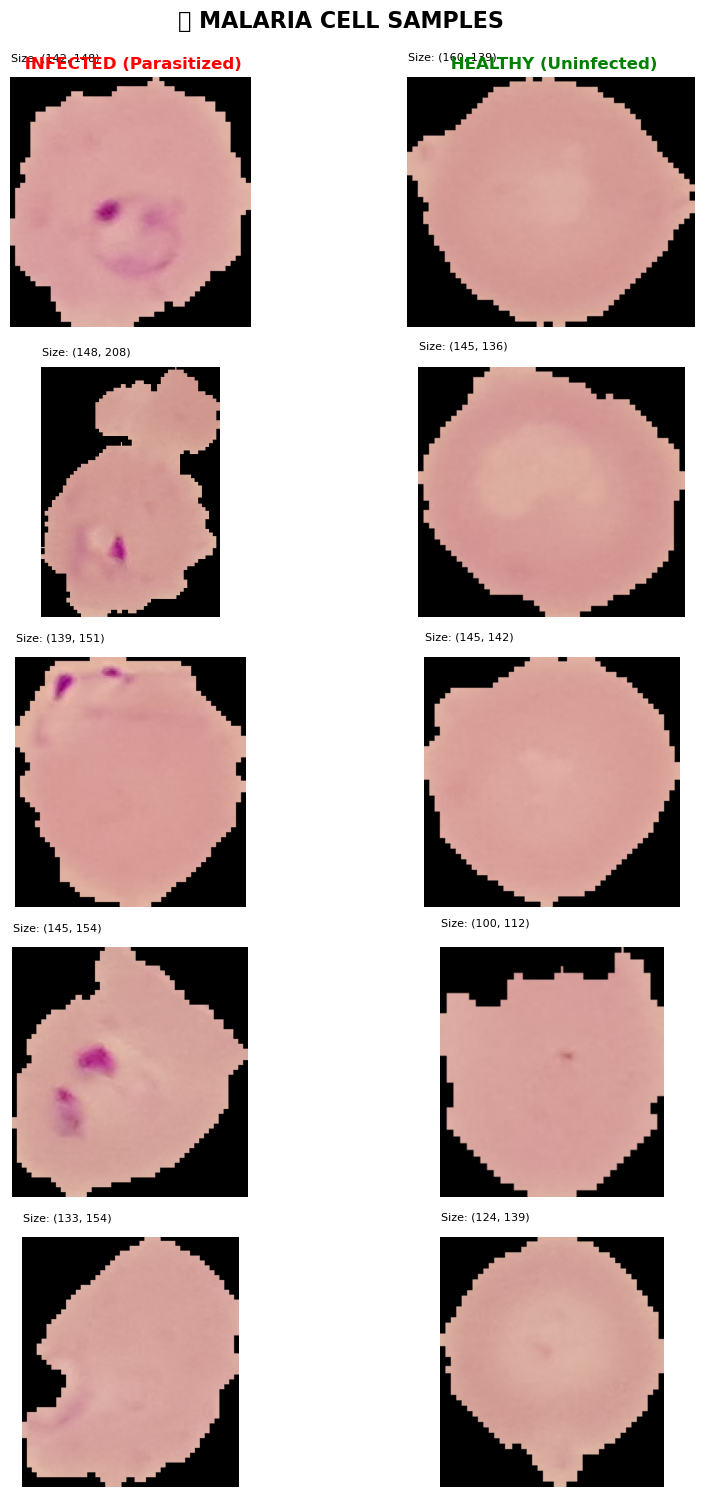

 VISUAL ANALYSIS
🦠 INFECTED cells: Look for dark purple/blue spots (parasites)
✅ HEALTHY cells: Uniform pink/purple color, no dark spots

 IMAGE PROPERTIES ANALYSIS
 Sample image sizes found: 20 unique size(s)
   Size (139, 139): 1 infected, 0 healthy (from 10 samples each)
   Size (139, 142): 1 infected, 0 healthy (from 10 samples each)
   Size (139, 151): 1 infected, 0 healthy (from 10 samples each)
   Size (130, 118): 0 infected, 1 healthy (from 10 samples each)
   Size (154, 124): 1 infected, 0 healthy (from 10 samples each)
   Size (148, 208): 1 infected, 0 healthy (from 10 samples each)
   Size (145, 136): 0 infected, 1 healthy (from 10 samples each)
   Size (145, 142): 0 infected, 1 healthy (from 10 samples each)
   Size (169, 145): 1 infected, 0 healthy (from 10 samples each)
   Size (145, 154): 1 infected, 0 healthy (from 10 samples each)
   Size (118, 118): 0 infected, 1 healthy (from 10 samples each)
   Size (145, 172): 0 infected, 1 healthy (from 10 samples each)
   Size (1

In [ ]:
# Function to load and display images
def visualize_samples(num_samples=5):
    """
    Display sample images from both classes side by side
    
    Args:
        num_samples: Number of samples to display from each class
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    
    # Set column titles
    fig.suptitle('🔬 MALARIA CELL SAMPLES', fontsize=16, fontweight='bold', y=0.995)
    axes[0, 0].set_title(' INFECTED (Parasitized)', fontsize=12, fontweight='bold', color='red')
    axes[0, 1].set_title(' HEALTHY (Uninfected)', fontsize=12, fontweight='bold', color='green')
    
    for i in range(num_samples):
        # Load infected cell
        infected_img_path = os.path.join(PARASITIZED_DIR, parasitized_images[i])
        infected_img = Image.open(infected_img_path)
        
        # Load healthy cell
        healthy_img_path = os.path.join(UNINFECTED_DIR, uninfected_images[i])
        healthy_img = Image.open(healthy_img_path)
        
        # Display infected
        axes[i, 0].imshow(infected_img)
        axes[i, 0].axis('off')
        axes[i, 0].text(0, -10, f'Size: {infected_img.size}', fontsize=8)
        
        # Display healthy
        axes[i, 1].imshow(healthy_img)
        axes[i, 1].axis('off')
        axes[i, 1].text(0, -10, f'Size: {healthy_img.size}', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 60)
    print(" VISUAL ANALYSIS")
    print("=" * 60)
    print("🦠 INFECTED cells: Look for dark purple/blue spots (parasites)")
    print("✅ HEALTHY cells: Uniform pink/purple color, no dark spots")
    print("=" * 60)

# Display samples
visualize_samples(num_samples=5)

# Analyze image properties
print("\n" + "=" * 60)
print(" IMAGE PROPERTIES ANALYSIS")
print("=" * 60)


# Sample a few images to check properties
sample_sizes_infected = []
sample_sizes_healthy = []

for i in range(10):  # Check 10 samples
    # Infected
    img_path = os.path.join(PARASITIZED_DIR, parasitized_images[i])
    img = Image.open(img_path)
    sample_sizes_infected.append(img.size)
    
    # Healthy
    img_path = os.path.join(UNINFECTED_DIR, uninfected_images[i])
    img = Image.open(img_path)
    sample_sizes_healthy.append(img.size)

# Check if all sizes are the same
unique_sizes = set(sample_sizes_infected + sample_sizes_healthy)

print(f" Sample image sizes found: {len(unique_sizes)} unique size(s)")
for size in unique_sizes:
    count_infected = sample_sizes_infected.count(size)
    count_healthy = sample_sizes_healthy.count(size)
    print(f"   Size {size}: {count_infected} infected, {count_healthy} healthy (from 10 samples each)")

if len(unique_sizes) == 1:
    print(f"\n All images are the SAME size: {list(unique_sizes)[0]}")
    print("   → No resizing needed during preprocessing!")
else:
    print(f"\n  Images have DIFFERENT sizes!")
    print("   → We'll need to resize all images to a fixed size for CNN input")


 Target image size: 128×128
 Training transforms: Resize + Augmentation + ToTensor
 Validation transforms: Resize + ToTensor (no augmentation)

 Testing transforms...
Original: (142, 148) → Transformed: torch.Size([3, 128, 128])
Pixel range: [0.000, 0.863]


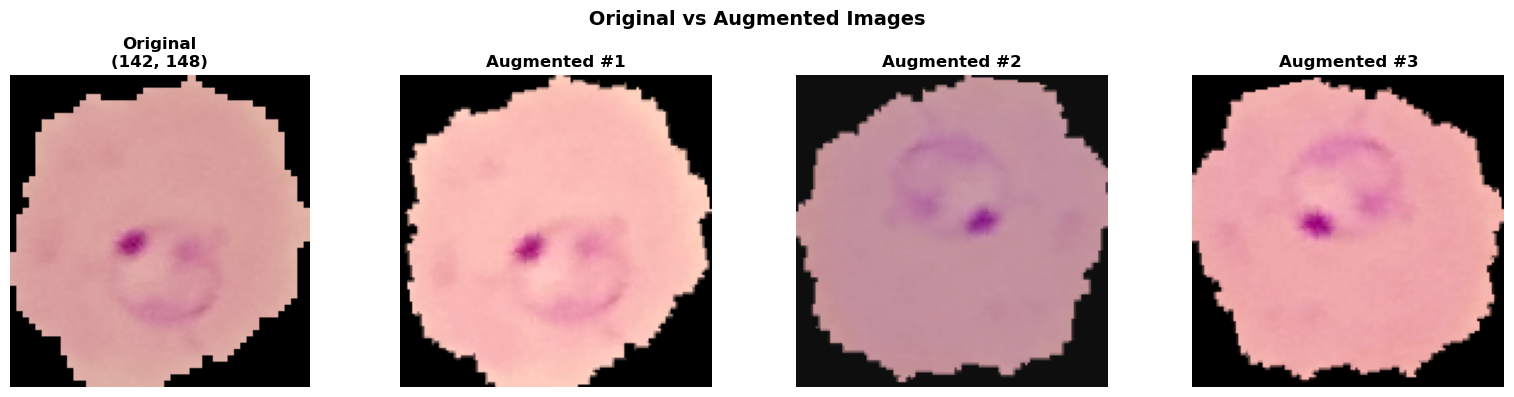

 Transforms ready! Each training image will be augmented randomly.


In [4]:


# Define image size for CNN input
IMG_SIZE = 128  # All images will be resized to 128x128

print(f" Target image size: {IMG_SIZE}×{IMG_SIZE}")

# TRAINING TRANSFORMS (with augmentation)

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
])

print(" Training transforms: Resize + Augmentation + ToTensor")


# VALIDATION/TEST TRANSFORMS (NO augmentation)

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(" Validation transforms: Resize + ToTensor (no augmentation)")


# TEST THE TRANSFORMS

print("\n Testing transforms...")

# Load one sample image
sample_img_path = os.path.join(PARASITIZED_DIR, parasitized_images[0])
sample_img = Image.open(sample_img_path)

# Apply training transform
transformed_tensor = train_transform(sample_img)

print(f"Original: {sample_img.size} → Transformed: {transformed_tensor.shape}")
print(f"Pixel range: [{transformed_tensor.min():.3f}, {transformed_tensor.max():.3f}]")

# Visualize transformation
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle(' Original vs Augmented Images', fontsize=14, fontweight='bold')

# Original
axes[0].imshow(sample_img)
axes[0].set_title(f'Original\n{sample_img.size}', fontweight='bold')
axes[0].axis('off')

# Apply transform 3 times to see augmentation variations
for i in range(1, 4):
    augmented_tensor = train_transform(sample_img)
    augmented_img = augmented_tensor.permute(1, 2, 0).numpy()
    axes[i].imshow(augmented_img)
    axes[i].set_title(f'Augmented #{i}', fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(" Transforms ready! Each training image will be augmented randomly.")

✅ Dataset class created
Total samples: 27,558 (Infected: 13,779, Healthy: 13,779)
Split → Train: 19,290 | Val: 4,134 | Test: 4,134
 Datasets ready: Train=19,290, Val=4,134, Test=4,134
Sample: torch.Size([3, 128, 128]), Label: 1, Range: [0.00, 1.00]


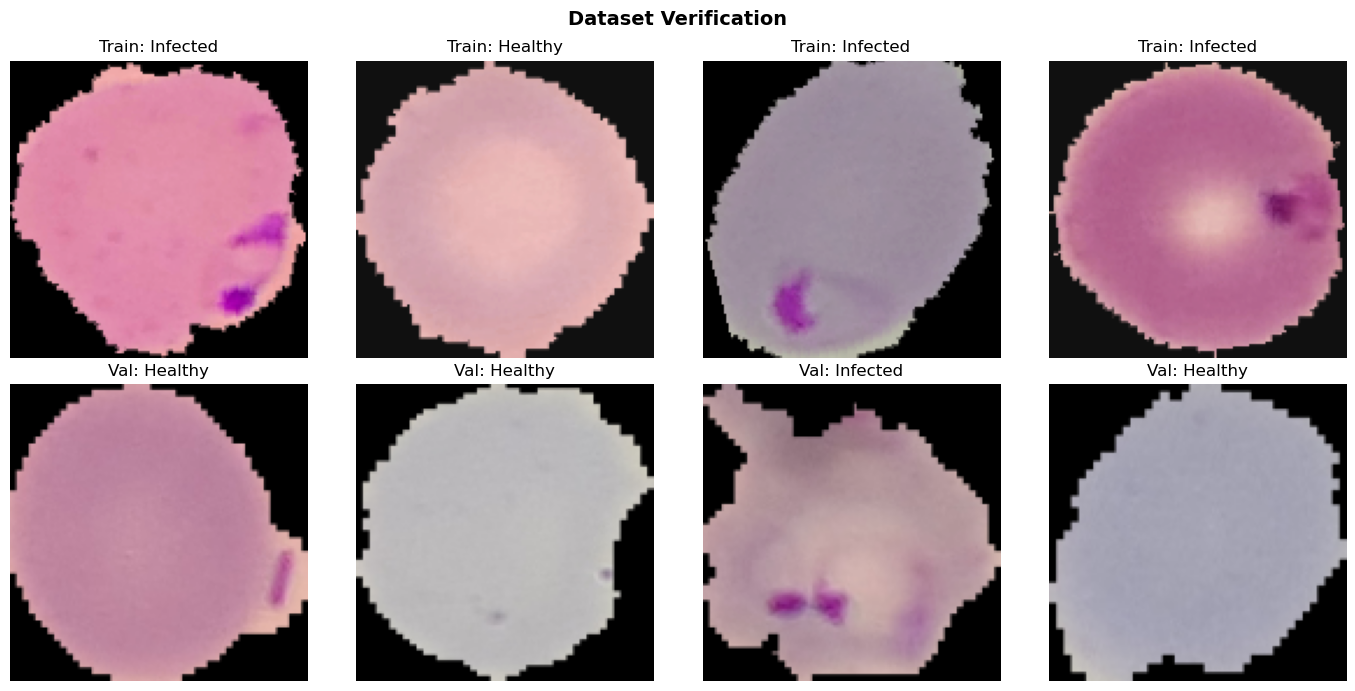

 All datasets verified and ready for training!


In [5]:
class MalariaDataset(Dataset):
    """Custom PyTorch Dataset for Malaria Cell Images"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ Dataset class created")



# Collect all paths and labels
X = []  # Image paths
y = []  # Labels

# Infected images (label=1)
for img_name in parasitized_images:
    X.append(os.path.join(PARASITIZED_DIR, img_name))
    y.append(1)

# Healthy images (label=0)
for img_name in uninfected_images:
    X.append(os.path.join(UNINFECTED_DIR, img_name))
    y.append(0)

print(f"Total samples: {len(X):,} (Infected: {sum(y):,}, Healthy: {len(y)-sum(y):,})")



# Split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y
)

# Split temp: 50/50 → 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp
)

print(f"Split → Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")



train_dataset = MalariaDataset(X_train, y_train, transform=train_transform)
val_dataset = MalariaDataset(X_val, y_val, transform=val_transform)
test_dataset = MalariaDataset(X_test, y_test, transform=val_transform)

print(f" Datasets ready: Train={len(train_dataset):,}, Val={len(val_dataset):,}, Test={len(test_dataset):,}")



# Test one sample
sample_img, sample_label = train_dataset[0]
print(f"Sample: {sample_img.shape}, Label: {sample_label}, Range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")

# Quick visualization
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Dataset Verification', fontsize=14, fontweight='bold')

# Training samples (with augmentation)
for i in range(4):
    img, label = train_dataset[i]
    axes[0, i].imshow(img.permute(1, 2, 0))
    axes[0, i].set_title(f"Train: {'Infected' if label==1 else 'Healthy'}")
    axes[0, i].axis('off')

# Validation samples (no augmentation)
for i in range(4):
    img, label = val_dataset[i]
    axes[1, i].imshow(img.permute(1, 2, 0))
    axes[1, i].set_title(f"Val: {'Infected' if label==1 else 'Healthy'}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print(" All datasets verified and ready for training!")

 Batch size: 32
 DataLoaders created!
   Train batches: 603
   Val batches: 130
   Test batches: 130

 Testing one batch...
Batch shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])
Pixel range: [0.000, 1.000]
Sample labels: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


C:\Users\Win10\AppData\Local\Temp\ipykernel_15812\2026819800.py:57: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_15812\2026819800.py:57: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Win10\anaconda3\envs\Myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Win10\anaconda3\envs\Myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


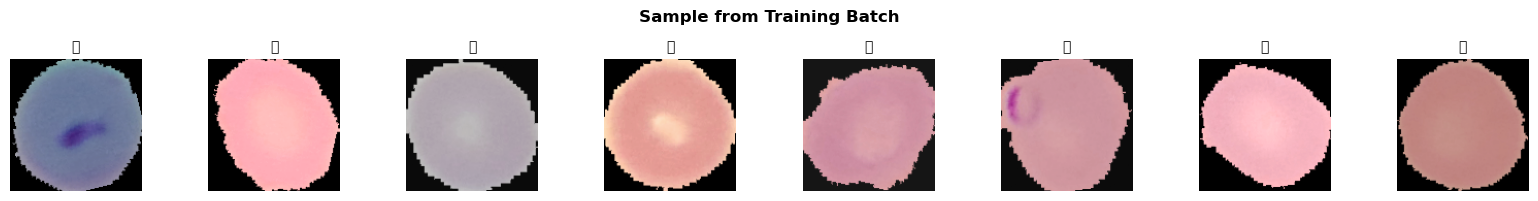


 DataLoaders ready for training!
 Each epoch will process 603 batches


In [6]:

# Define batch size
BATCH_SIZE = 32

print(f" Batch size: {BATCH_SIZE}")

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f" DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Test one batch
print(f"\n Testing one batch...")
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Pixel range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Sample labels: {labels[:10].tolist()}")

# Quick visualization 
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
fig.suptitle('Sample from Training Batch', fontsize=12, fontweight='bold')

for idx in range(8):
    img = images[idx].permute(1, 2, 0).cpu().numpy()
    label = labels[idx].item()
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{'🦠' if label==1 else '✅'}", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n DataLoaders ready for training!")
print(f" Each epoch will process {len(train_loader)} batches")

In [7]:
class MalariaCNN(nn.Module):
    def __init__(self):
        super(MalariaCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.3)
        
        # Convolutional Block 4
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(0.3)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.4)
        
        self.fc3 = nn.Linear(256, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        x = self.relu(self.bn7(self.conv7(x)))
        x = self.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC Layers
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.sigmoid(self.fc3(x))
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MalariaCNN().to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Device: {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Device: cuda
Total parameters: 9,696,417
Trainable parameters: 9,696,417


In [8]:
criterion = nn.BCELoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

print(f"Loss function: Binary Cross-Entropy")
print(f"Optimizer: AdamW (lr=0.001, weight_decay=0.01)")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

Loss function: Binary Cross-Entropy
Optimizer: AdamW (lr=0.001, weight_decay=0.01)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


C:\Users\Win10\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        predictions = (outputs >= 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [10]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            predictions = (outputs >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [11]:
num_epochs = 10
best_val_acc = 0.0
patience_counter = 0
early_stop_patience = 7

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Starting training...")
print(f"Total epochs: {num_epochs}")
print(f"Early stopping patience: {early_stop_patience}")
print("-" * 70)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_malaria_model.pth')
        print(f"  Model saved! Best Val Acc: {best_val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{early_stop_patience})")
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break
    
    print("-" * 70)

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Starting training...
Total epochs: 10
Early stopping patience: 7
----------------------------------------------------------------------


KeyboardInterrupt: 

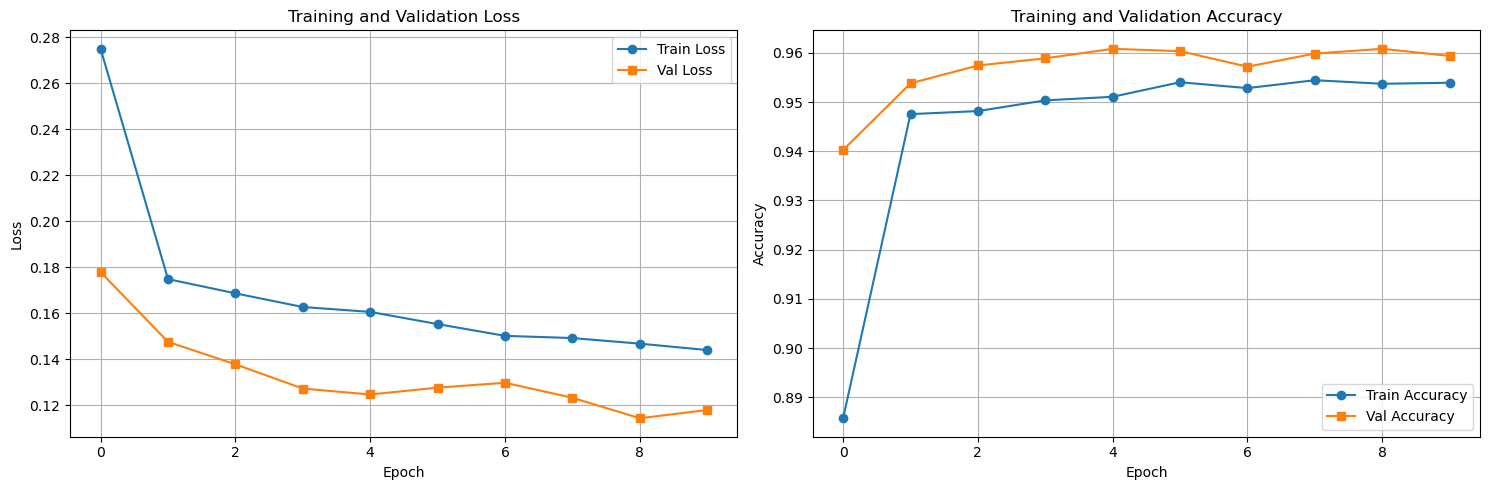

Final Training Accuracy: 0.9539
Final Validation Accuracy: 0.9594


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

In [ ]:
model.load_state_dict(torch.load('best_malaria_model.pth'))
model.eval()

test_loss = 0.0
correct = 0
total = 0

all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * images.size(0)
        
        predictions = (outputs >= 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(outputs.cpu().numpy())

test_loss = test_loss / total
test_acc = correct / total

print("=" * 60)
print(" TEST SET EVALUATION")
print("=" * 60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Correct Predictions: {correct}/{total}")
print("=" * 60)

C:\Users\Win10\AppData\Local\Temp\ipykernel_14844\3524473522.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_malaria_model.pth'))


 TEST SET EVALUATION
Test Loss: 0.1370
Test Accuracy: 0.9589
Correct Predictions: 3964/4134



Confusion Matrix:
[[2009   58]
 [ 112 1955]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.95      0.97      0.96      2067
    Infected       0.97      0.95      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



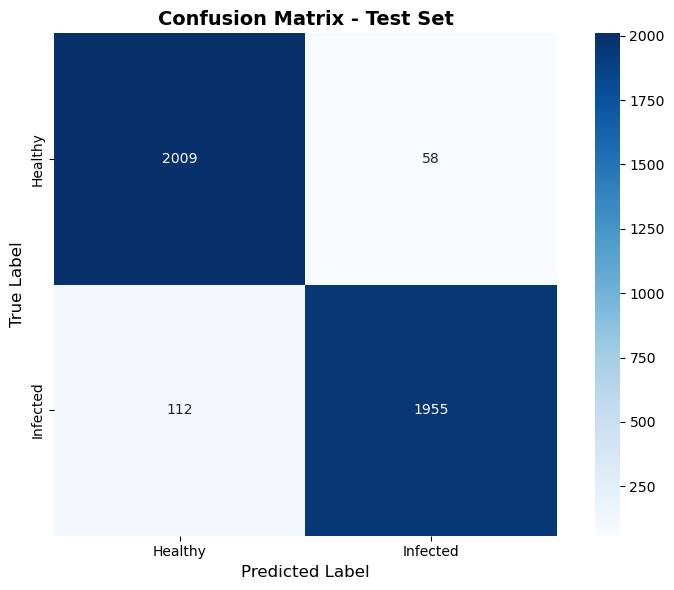


True Negatives (Healthy correctly identified): 2009
False Positives (Healthy misclassified as Infected): 58
False Negatives (Infected misclassified as Healthy): 112
True Positives (Infected correctly identified): 1955


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

all_predictions = np.array(all_predictions).flatten()
all_labels = np.array(all_labels).flatten()

cm = confusion_matrix(all_labels, all_predictions)

print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, 
                        target_names=['Healthy', 'Infected']))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Infected'],
            yticklabels=['Healthy', 'Infected'],
            cbar=True, square=True)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Healthy correctly identified): {tn}")
print(f"False Positives (Healthy misclassified as Infected): {fp}")
print(f"False Negatives (Infected misclassified as Healthy): {fn}")
print(f"True Positives (Infected correctly identified): {tp}")

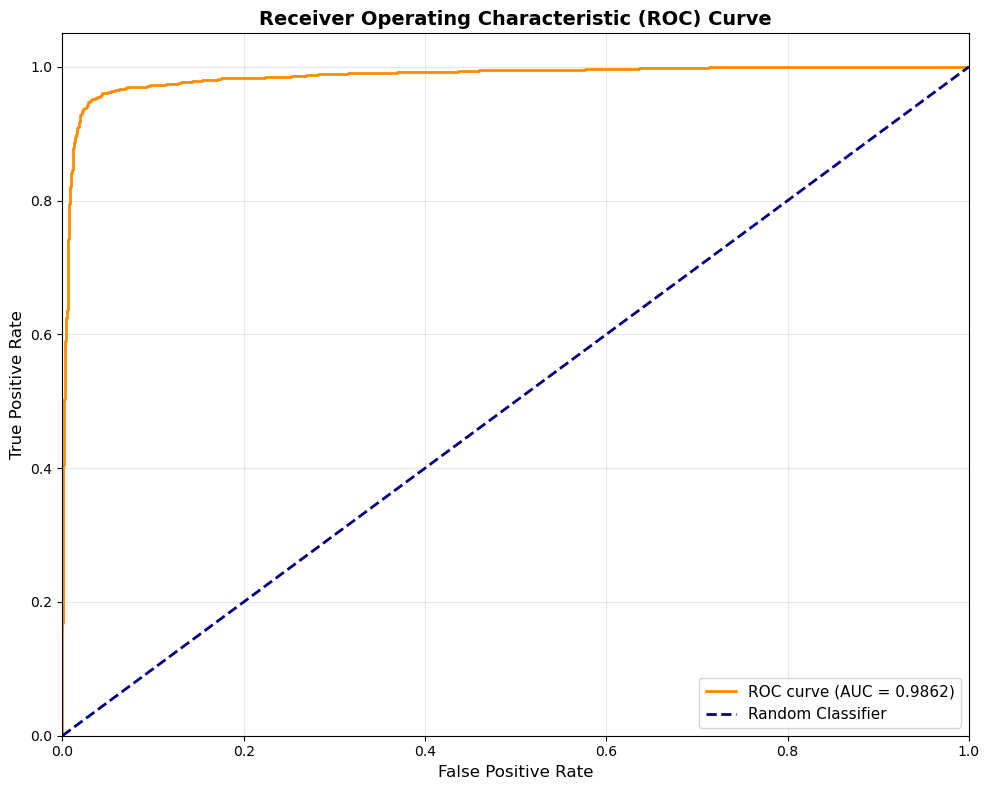

Area Under Curve (AUC): 0.9862


In [ ]:
from sklearn.metrics import roc_curve, auc

all_probabilities = np.array(all_probabilities).flatten()

fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
        label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', 
        fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Area Under Curve (AUC): {roc_auc:.4f}")

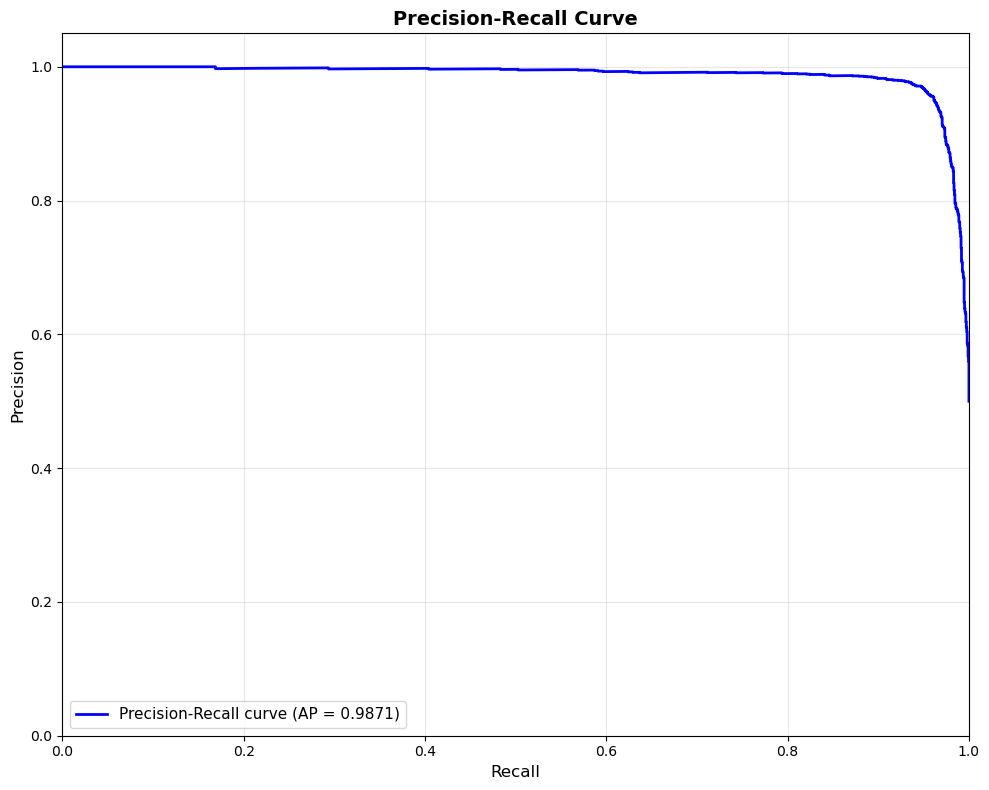

Average Precision Score: 0.9871


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_labels, all_probabilities)
avg_precision = average_precision_score(all_labels, all_probabilities)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2,
        label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

print(f"Average Precision Score: {avg_precision:.4f}")

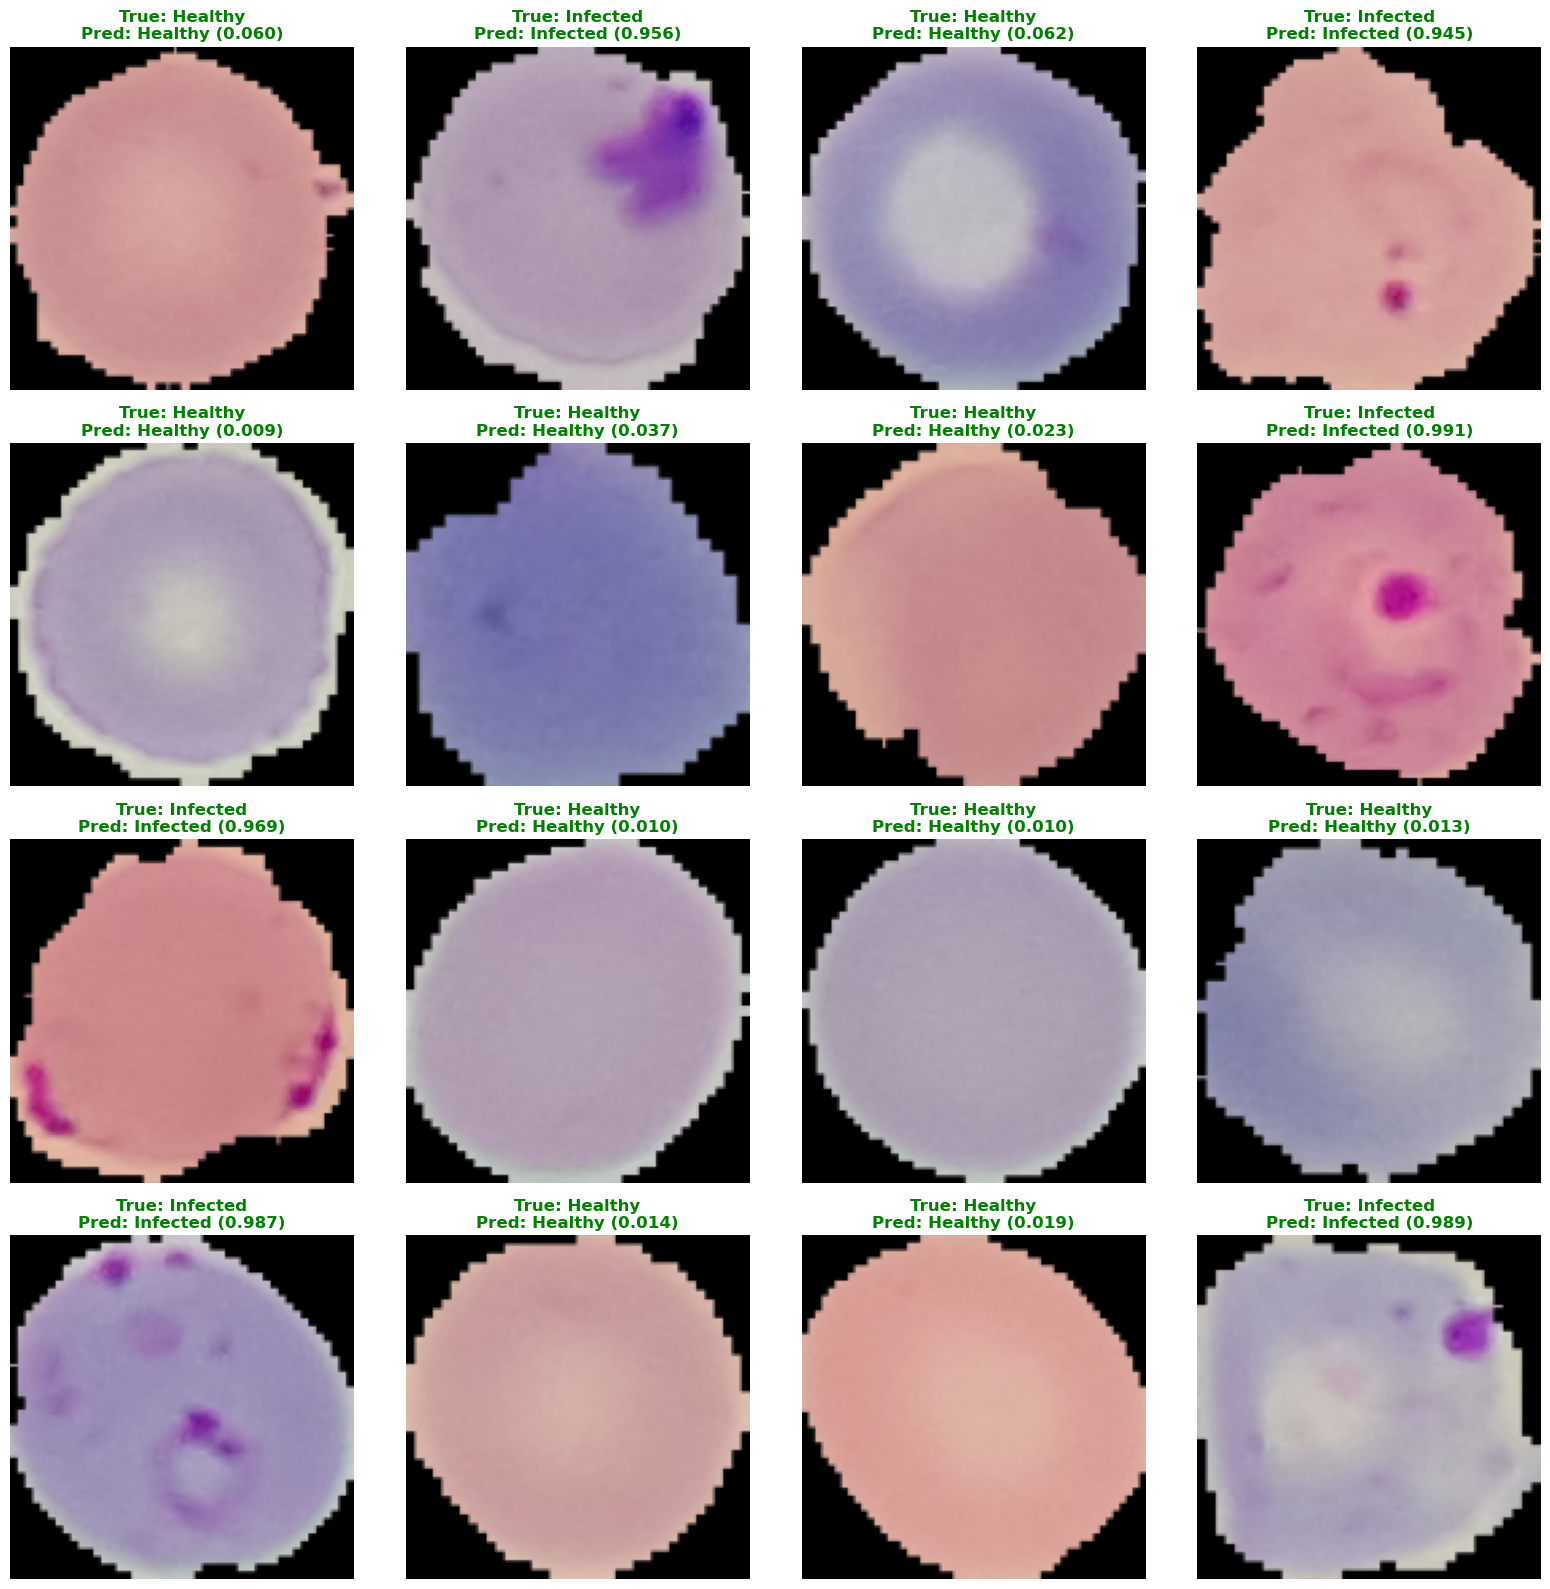

In [ ]:
def show_predictions(num_samples=16):
    model.eval()
    
    images_shown = 0
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            predictions = (outputs >= 0.5).float()
            
            for i in range(min(len(images), num_samples - images_shown)):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                true_label = int(labels[i].cpu().item())
                pred_label = int(predictions[i].cpu().item())
                prob = outputs[i].cpu().item()
                
                axes[images_shown].imshow(img)
                
                true_text = "Infected" if true_label == 1 else "Healthy"
                pred_text = "Infected" if pred_label == 1 else "Healthy"
                
                color = 'green' if true_label == pred_label else 'red'
                
                axes[images_shown].set_title(
                    f'True: {true_text}\nPred: {pred_text} ({prob:.3f})',
                    color=color, fontweight='bold'
                )
                axes[images_shown].axis('off')
                
                images_shown += 1
                
                if images_shown >= num_samples:
                    break
            
            if images_shown >= num_samples:
                break
    
    plt.tight_layout()
    plt.show()

show_predictions(num_samples=16)

In [ ]:
print("=" * 70)
print(" FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(f"\nModel Architecture: Custom CNN")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print(f"\nDataset:")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Validation samples: {len(val_dataset):,}")
print(f"  Test samples: {len(test_dataset):,}")

print(f"\nFinal Training Metrics:")
print(f"  Train Loss: {train_losses[-1]:.4f}")
print(f"  Train Accuracy: {train_accs[-1]:.4f}")

print(f"\nFinal Validation Metrics:")
print(f"  Val Loss: {val_losses[-1]:.4f}")
print(f"  Val Accuracy: {val_accs[-1]:.4f}")
print(f"  Best Val Accuracy: {best_val_acc:.4f}")

print(f"\nTest Set Metrics:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  AUC-ROC: {roc_auc:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives: {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  True Positives: {tp:,}")

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  F1-Score: {f1_score:.4f}")

print("=" * 70)

 FINAL MODEL PERFORMANCE SUMMARY

Model Architecture: Custom CNN
Total Parameters: 9,696,417
Trainable Parameters: 9,696,417

Dataset:
  Training samples: 19,290
  Validation samples: 4,134
  Test samples: 4,134

Final Training Metrics:
  Train Loss: 0.1440
  Train Accuracy: 0.9539

Final Validation Metrics:
  Val Loss: 0.1179
  Val Accuracy: 0.9594
  Best Val Accuracy: 0.9608

Test Set Metrics:
  Test Loss: 0.1370
  Test Accuracy: 0.9589
  AUC-ROC: 0.9862
  Average Precision: 0.9871

Confusion Matrix Breakdown:
  True Negatives: 2,009
  False Positives: 58
  False Negatives: 112
  True Positives: 1,955

Detailed Metrics:
  Sensitivity (Recall): 0.9458
  Specificity: 0.9719
  Precision: 0.9712
  F1-Score: 0.9583


In [ ]:
import pickle

history = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'roc_auc': roc_auc,
    'avg_precision': avg_precision,
    'confusion_matrix': cm,
    'all_predictions': all_predictions,
    'all_labels': all_labels,
    'all_probabilities': all_probabilities
}

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Training history saved to 'training_history.pkl'")
print("Model weights saved to 'best_malaria_model.pth'")
print("\nProject complete!")

Training history saved to 'training_history.pkl'
Model weights saved to 'best_malaria_model.pth'

Project complete!
